### Technical Report

[Problem Statement](#1) | [Data](#2) | [EDA](#3) | [Image preprocessing](#4) | [Model](model.ipynb) | [Results](model.ipynb) | [Summary](model.ipynb)

---

## <a name="1">Problem statement/goal</a>
Predict whether there is pizza in a photo... a pizza detector if you will. This was really the first step in a more complex problem of first recognizing different pictured foods and then predicting calories from those food photos.


---

## <a name="2">Data</a>

[The Food-101 Data Set](https://www.vision.ee.ethz.ch/datasets_extra/food-101/) & [ImageNet](http://image-net.org/synset?wnid=n07873807)

The data set is comprised of 2,000 photos of foods that are not pizza plus 2,000 photos of pizza that come from randomly sampling The Food-101 Data Set (and supplementing an additional 1,000 photos of pizza from ImageNet). The The Food-101 Data Set dataset includes a 101 food categories, with 1,000 images per category taken from [Foodspotting.com](http://www.foodspotting.com/). The training images still contain some amount of noise — mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum height of 512 pixels. 

In [1]:
import os
print os.listdir('/Users/VanessaG/Desktop/DSI-SF-2-vnessified/capstone/data_sources/food-101/images')[2:]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

---

## <a name="3">"EDA"</a>
Because my data is image based, typical EDA doesn't really make sense. But I do look into some basic info like RGB, HSV and image dimenions. 

In [61]:
import glob

import fnmatch
import pandas as pd
import numpy as np

import cv2
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import seaborn as sns
import matplotlib
from matplotlib import colors
from matplotlib import pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')
from __future__ import division

#### OpenCV
- images represented by numpy arrays
- image.shape => pixel height, width and 3 channels (BGR - blue and red channels need to be swapped)
- Matplotlib expects RGB image - use openCV conversion function cv2.cvtColor (or directly manipulate the numpy array)
- cv2.mean, cv2.COLOR_BGR2HSV, cv2.calcHist

In [6]:
# create list of all my image files
images = []
for root, dirnames, filenames in os.walk('/Users/VanessaG/Desktop/pizza_class_data/'):
    for filename in fnmatch.filter(filenames, '*.jpg'):
        images.append(os.path.join(root, filename))

In [87]:
# create lists for dataframe of image info - rgb, hsv, image height & width

data = []
for img in images:
    image = cv2.imread(img)
    data.append(image)
    
rgb_means = []
hsv_means = []
img_height = []
img_width = [] 

for i in data:
    means = cv2.mean(i)
    rgb_means.append(means)
    means2 = cv2.mean(cv2.cvtColor(i, cv2.COLOR_BGR2HSV))
    hsv_means.append(means2)
    img_height.append(i.shape[0])
    img_width.append(i.shape[1])

In [71]:
df1 = pd.DataFrame(rgb_means, columns=['blue', 'green', 'red', 'scalar'])
df1.drop('scalar', axis=1, inplace=True)
df2 = pd.DataFrame(hsv_means, columns=['hue', 'sat', 'val', 'scalar'])
df2.drop('scalar', axis=1, inplace=True)
df = pd.concat([df1, df2], axis=1)

In [75]:
df['full_path'] = images

In [76]:
df['label'] = df.full_path.map(lambda x: 0 if '/not_pizza/' in x else 1)

In [77]:
df['short_path'] = df['full_path'].replace({'/Users/VanessaG/Desktop/pizza_class_data/': ''}, regex=True)

In [115]:
df['img_height'] = img_height
df['img_width'] = img_width
df['total_px'] = df.img_height * df.img_width
df = df[['label', 'red', 'green', 'blue','hue', 'sat', 'val', 'img_height', 'img_width', 'total_px', 'short_path', 'full_path']]

In [116]:
df.head(2)

,label,red,green,blue,hue,sat,val,img_height,img_width,total_px,short_path,full_path
0,0,59.162537,31.081568,10.445669,18.120672,206.064468,59.274221,512,512,262144,train/not_pizza/10060.jpg,/Users/VanessaG/Desktop/pizza_class_data/train...
1,0,162.626228,115.462669,124.999763,102.017727,119.374016,173.185349,512,512,262144,train/not_pizza/1008028.jpg,/Users/VanessaG/Desktop/pizza_class_data/train...


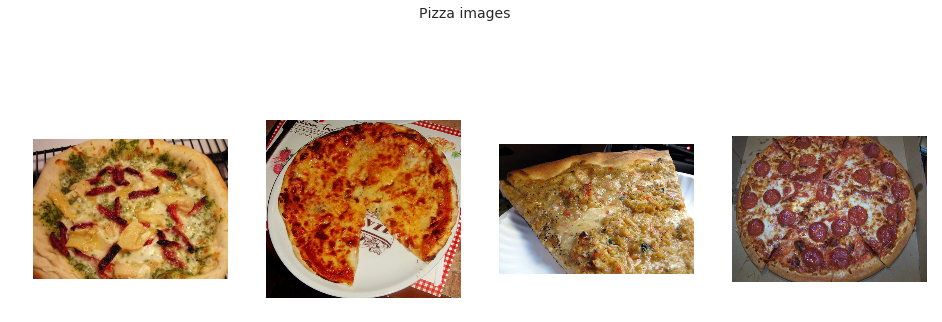

In [121]:
# displaying pizza images
fig, ax = plt.subplots(1,4,figsize=(16,6))

pizza = df.full_path[df.label == 1][996:1000]

images_plot = []
for img in pizza[:4]:
    image = load_img(img)
    images_plot.append(image)
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(images_plot[i])
    plt.axis("off")

plt.suptitle('Pizza images', size=14)
plt.show() 

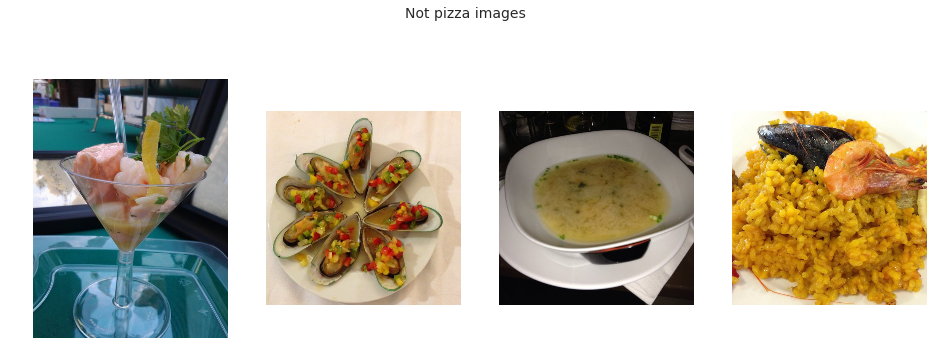

In [120]:
# displaying pizza images
fig, ax = plt.subplots(1,4,figsize=(16,6))

not_pizza = df.full_path[df.label == 0][996:1000]

images_plot = []
for img in not_pizza[:4]:
    image = load_img(img)
    images_plot.append(image)
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(images_plot[i])
    plt.axis("off")
    
plt.suptitle('Not pizza images', size=14)
plt.show() 

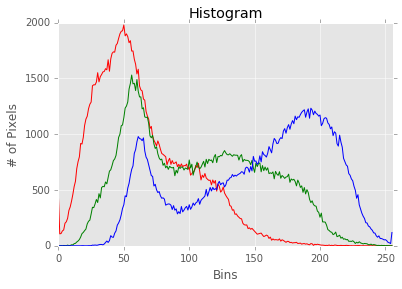

In [42]:
color = ['r', 'g', 'b']
for i, col in enumerate(color):
    histr = cv2.calcHist([image],[i],None,[256],[0,256])
    plt.plot(histr, color = col)
    plt.xlim([0,256])
    plt.title("Histogram")
    plt.xlabel("Bins")
    plt.ylabel("# of Pixels")
plt.show()

In [86]:
df.describe()

,label,red,green,blue,hue,sat,val,img_height,img_width
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.00000
mean,0.500000,140.911186,108.875251,81.332360,38.259611,126.027567,144.610423,446.798500,491.44775
std,0.500063,31.950226,27.582743,30.868956,21.390969,40.233401,31.086101,75.907809,47.64875
min,0.000000,24.878749,15.890667,1.836857,7.294048,27.817089,25.706172,195.000000,280.00000
25%,0.000000,119.571158,91.895652,60.080588,21.907297,96.669185,124.517691,375.000000,500.00000
50%,0.500000,140.754682,109.095836,80.728067,33.270518,122.157010,144.647039,512.000000,512.00000
75%,1.000000,162.731640,125.963034,101.325074,49.584102,152.645701,165.299150,512.000000,512.00000
max,1.000000,239.870316,208.152988,195.144639,156.153285,251.986397,239.900028,639.000000,800.00000


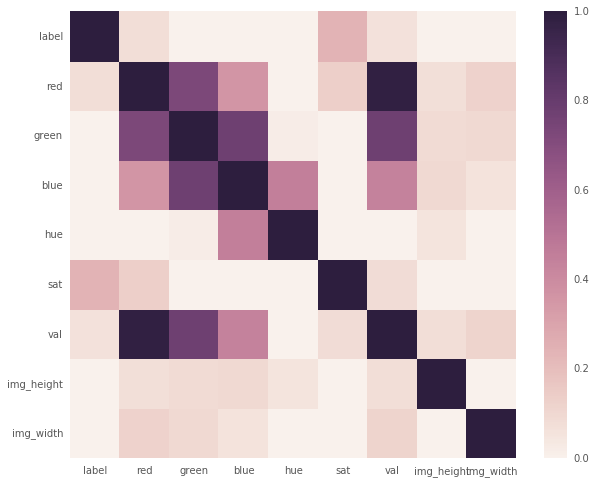

In [85]:
df_corr=df.corr()
fig = plt.figure(figsize=(10,8))
ax = fig.gca()
ax = sns.heatmap(df_corr, vmin=0, vmax=1)

---
## <a name="4">Image preprocessing</a>
There was no data cleaning other than [organizing the images](data_setup.ipynb) into correct directory structure required for the keras method `.flow_from_directory` but there was some image preprocessing using the ImageDataGenerator class. The goal with the preprocessing is to make the most of few training examples and "augment" via random transformations so model never sees the same image twice which helps prevent overfitting and model to generalize better.

In [122]:
# example of transformations
datagen = ImageDataGenerator(
    
        #integer value range in degrees(0-180) to randomly rotate images
        rotation_range=40,
    
        rescale=1./255,
    
        #width_shift & height_shift are float ranges (as fraction of total width or height)
        #within which to randomly translate/shift
        width_shift_range=0.2,
        height_shift_range=0.2,
    
        #randomly applying shearing transformations
        shear_range=0.2,
    
        #randomly zooming inside pictures
        zoom_range=0.2,
    
        #randomly flips half of the images horizontally
        #relevant when no assumptions of horizontal assymetry - ie real-world pictures
        horizontal_flip=True,
    
        #strategy for filling newly created pixels
        fill_mode='nearest')

In [123]:
# load PIL image with keras helper function
img = load_img('/Users/VanessaG/Desktop/pizza_class_data/train/pizza/40449.jpg') 

# convert to numpy array 
x = img_to_array(img)

# reshape numpy array - required for keras
x = x.reshape((1,) + x.shape)  

In [124]:
# .flow() generates batches of randomly transformed images and saves the resulting images to the specified directory
i = 0
for batch in datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='pizza', save_format='jpg'):
    i += 1
    if i > 20:
        # otherwise the generator would loop indefinitely
        break  

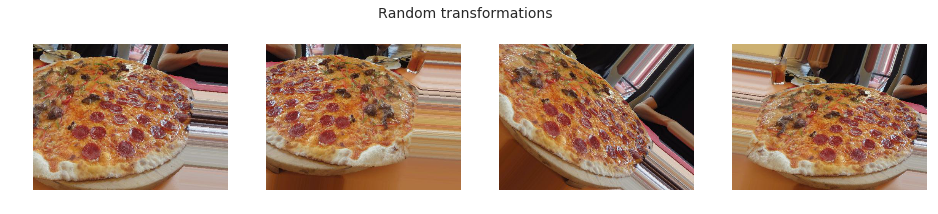

In [127]:
pizza_transformed = [f for f in glob.glob('./preview/*') if f.endswith('.jpg')]

fig, ax = plt.subplots(1,4,figsize=(16,6))

images = []
for img in pizza_transformed[0:4]:
    image = load_img(img)
    images.append(image)
for i in range(4):
    plt.subplot(2,4,i+1)
    plt.imshow(images[i])
    plt.axis("off")

plt.suptitle('Random transformations', size=14)
plt.show() 